$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$

$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

$$\newcommand{\ketbra}[2]{\ket{#1}\bra{#2}}$$



# Import de Modules

In [3]:
from qutip import *

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq


plt.switch_backend("module://ipykernel.pylab.backend_inline")
plt.rcParams.update({'font.size': 32})

# 1. Système à deux niveaux avec drive

### Définition des vecteurs de base

In [4]:
etat_g = basis(2,0)  # |g>
etat_e = basis(2,1)  # |e>

gg = etat_g*etat_g.dag()  # |g><g|
ee = etat_e*etat_e.dag()  # |e><e|
ge = etat_g*etat_e.dag()  # |e><e|
eg = etat_e*etat_g.dag()  # |e><g|

### Définition du Hamiltonien et probabilité de transition ($P_{g\to e}(t)$)




Rappel théorique: 

$$\boxed{P_{g \rightarrow e}(t)=\frac{|\Omega|^2}{|\Omega|^2+\Delta^2} \sin ^2\left(t / 2 \sqrt{\Delta^2+|\Omega|^2}\right)}$$


In [5]:
Delta = 2
drive = 1
psi0 = etat_g

# -------------------

H0 = Delta*ee 

Hint = 0.5*(drive*eg + np.conjugate(drive)*ge)


# -------------------

H = H0 + Hint

T = 2*np.pi/abs(drive) # Une "periode" d'oscillation (pour drive >> Delta)

tmax = T
t = np.linspace(0,tmax,51)
            
result = mesolve(H, psi0, t) # permet d'obtenir la matrice densité/vecteur d'état pour chaque points en temps

P_ge = expect(ee ,result.states) # P<phi(t)|e><e|phi(t)> 




# print(result.states)

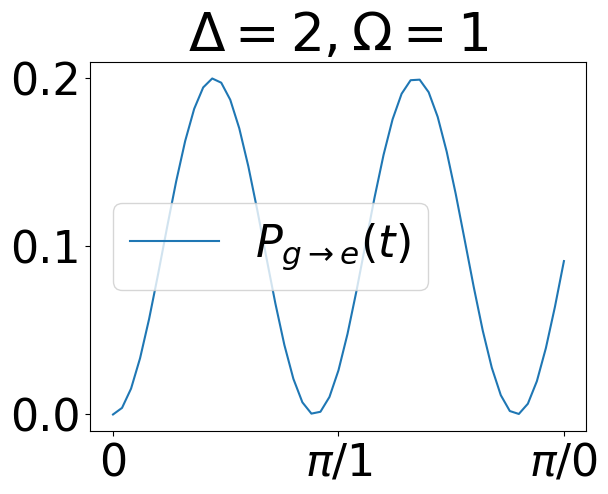

In [6]:
plt.plot(t, P_ge, label=r'$P_{g \rightarrow e} (t)$')
plt.legend()
plt.xticks([0,tmax/2, tmax], ["$0$", r"$\pi"+f"/{int(T/(tmax))}$", r"$\pi"+f"/{int(T/2/tmax)}$"])
plt.title(f"$\Delta={Delta}, \Omega={drive}$")
plt.show()

### Visualisation sur la sphère de Bloch

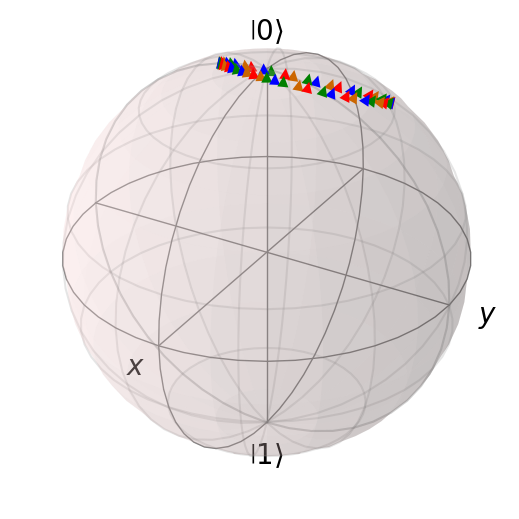

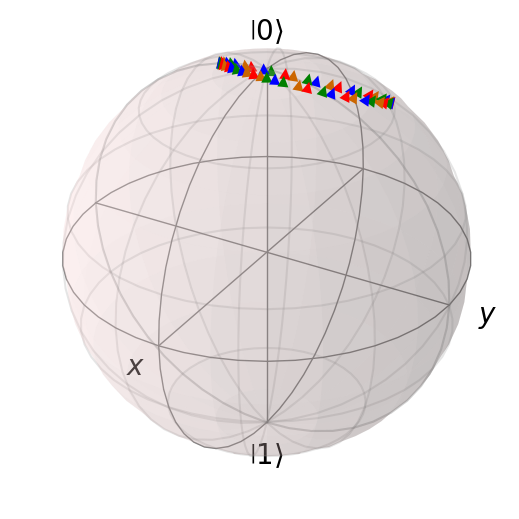

In [7]:
b = Bloch()
b.add_states(result.states)
b.vector_width = 0
b.show()

# Système à 3 niveau (Qutrit) (ou Qubit à faible anharmonicité)

[]

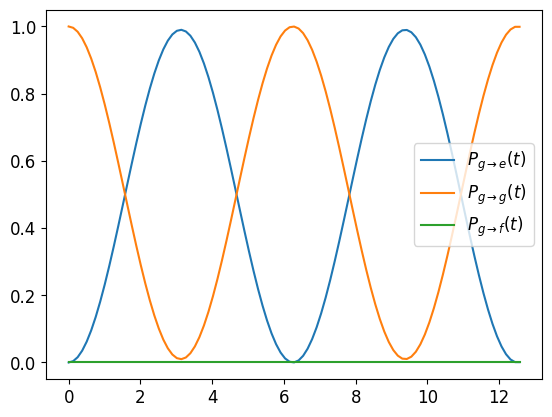

In [44]:
etat3_g = basis(3,0)  # |g>
etat3_e = basis(3,1)  # |e>
etat3_f = basis(3,2)  # |e>

Delta = 0.1

gg3 = etat3_g*etat3_g.dag()  # |g><g|
ee3 = etat3_e*etat3_e.dag()  # |e><e|
ge3 = etat3_g*etat3_e.dag()  # |g><e|
eg3 = etat3_e*etat3_g.dag()  # |e><g|
ff3 = etat3_f*etat3_f.dag()  # |f><f|
ef3 = etat3_e*etat3_f.dag()  # |e><f|
fe3 = etat3_f*etat3_e.dag()  # |f><e|

Anna = 1000

H0 = Delta * ee3  + (2*Delta+Anna)* ff3 
# Hint = 0.5*(drive*eg3 + np.conjugate(drive)*ge3) + 0.5*(drive*ef3 + np.conjugate(drive)*fe3)
Hint = drive/2 * eg3 + np.conjugate(drive)/2 * ge3 + drive/2 * fe3 + np.conjugate(drive)/2 * ef3
psi0= etat3_g

H = H0 + Hint

T = 2*2*np.pi/abs(drive) # Une "periode" d'oscillation (pour drive >> Delta)

tmax = T
t = np.linspace(0,tmax,101)
            
result = mesolve(H, psi0, t) # permet d'obtenir la matrice densité/vecteur d'état pour chaque points en temps

P_ge = expect(ee3 ,result.states) # P<phi(t)|e><e|phi(t)> 
plt.plot(t, P_ge, label=r'$P_{g \rightarrow e} (t)$')

P_gg = expect(gg3 ,result.states) # P<phi(t)|e><e|phi(t)> 
plt.plot(t, P_gg, label=r'$P_{g \rightarrow g} (t)$')

P_gf = expect(ff3 ,result.states) # P<phi(t)|e><e|phi(t)> 
plt.plot(t, P_gf, label=r'$P_{g \rightarrow f} (t)$')

plt.rcParams.update({'font.size': 12})

plt.legend()
plt.plot()


# Type d'Impulsions 

In [45]:
# échelle de temps sur laquelle calculer l'évolution

max_time = 5 # evolution temporelle entre 0 et max_time 
t = np.linspace(0,max_time,1001)

# option pour s'assurer que mesolve n'ignore pas le changement de cham
mesolve_max_step = 1e-1

### Impulsion rectengulaire

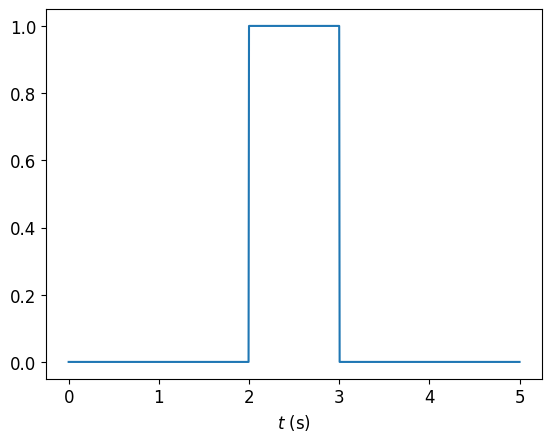

In [46]:
# définition de l'enveloppe du champ de pompe:
# cette enveloppe varie entre 0 et 1
pulse_width = 1  # impulsion pi/2 en seconde

def rect_enveloppe(t):
    return np.heaviside(t-max_time/2+pulse_width/2, 1)*np.heaviside(max_time/2-t+pulse_width/2, 1)

plt.plot(t,rect_enveloppe(t))
plt.xlabel("$t$ (s)")
plt.show()

### (Re)défintion du Hamiltonien

In [76]:
# difference en fréquence entre les transitions |g> -> |e> et |e> -> |f>
anharmonicite = 100

# décalage spectral entre la pompe et la transition |g> -> |e>
delta = 0.0

drive = 1/(4*pulse_width) * 2 * np.pi

H0 = delta * ee3 + (delta+anharmonicite) * ff3 

Hint = (drive/2 * eg3 + np.conjugate(drive)/2 * ge3) + (drive/2 * fe3 + np.conjugate(drive)/2 * ef3)

def H(t, args):
    enveloppe = args[0]
    """ Fonction permettant de calculer le Hamiltonien à chaque temps t. """
    return H0 + enveloppe(t)*Hint


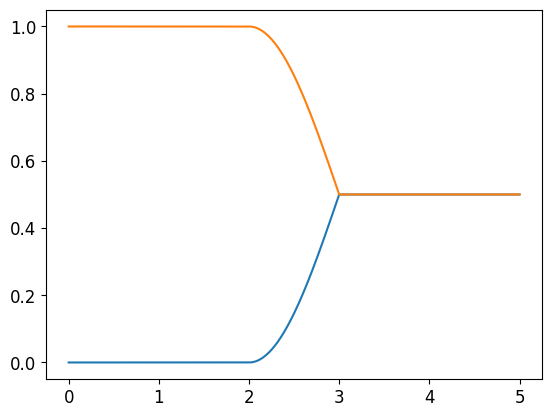

In [77]:
result = mesolve(H, etat3_g, t,[], args=[rect_enveloppe], options=Options(max_step=mesolve_max_step))


plt.plot(t, expect(ee3, result.states))
plt.plot(t, expect(gg3, result.states))

### Fidélité

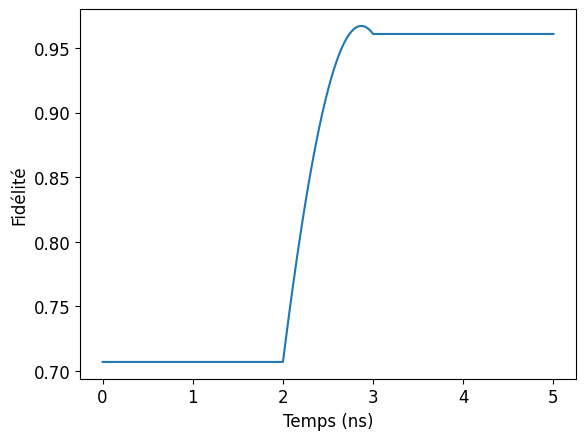

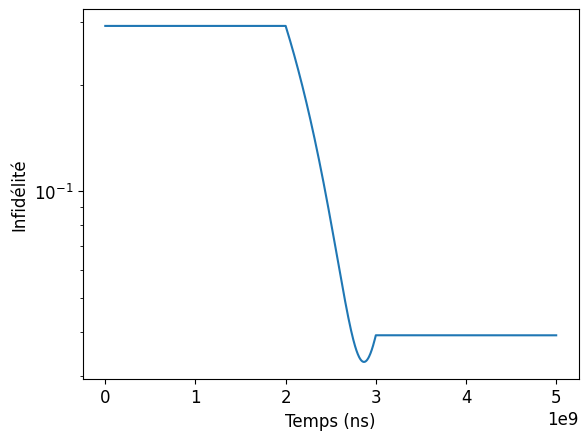

In [66]:
fidelite_rect = [fidelity(1/np.sqrt(2)*(etat3_g-1j*etat3_e), state) for state in result.states]
plt.plot(t,fidelite_rect)
plt.ylabel('Fidélité')
plt.xlabel('Temps (ns)')
plt.show()
plt.semilogy(t*1e9,1-np.array(fidelite_rect))
plt.ylabel('Infidélité')
plt.xlabel('Temps (ns)')
plt.show()

### Impulsion gaussienne

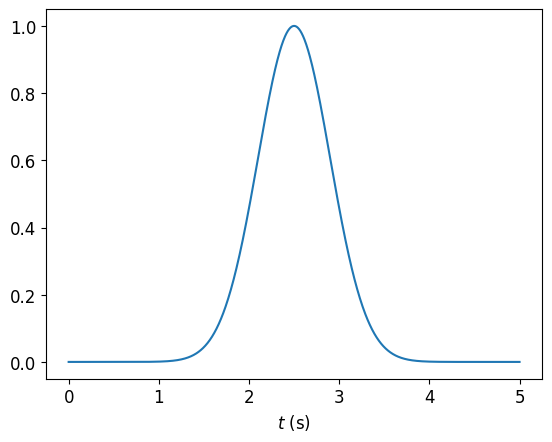

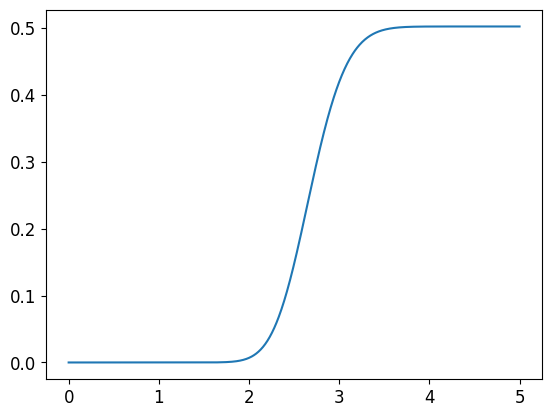

In [78]:
alpha = 1.25
gaus_width = pulse_width/(2*alpha)
def gaus_enveloppe(t):
    return np.exp(-(t-max_time/2)**2/(2*gaus_width**2))

plt.plot(t, gaus_enveloppe(t))
plt.xlabel("$t$ (s)")
plt.show()

result_gauss = mesolve(H, etat3_g, t, [],[], args=[gaus_enveloppe], options=Options(max_step=mesolve_max_step))
plt.plot(t, expect(ee3, result_gauss.states))


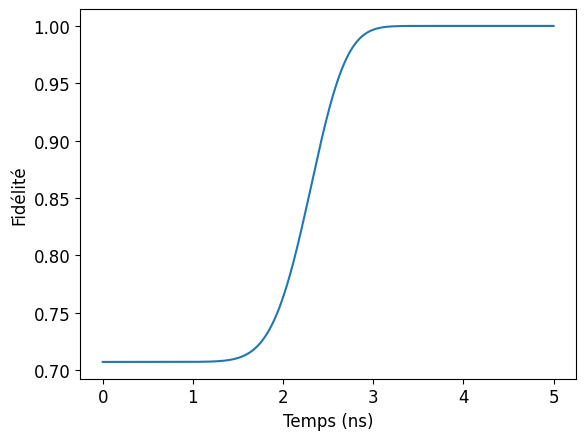

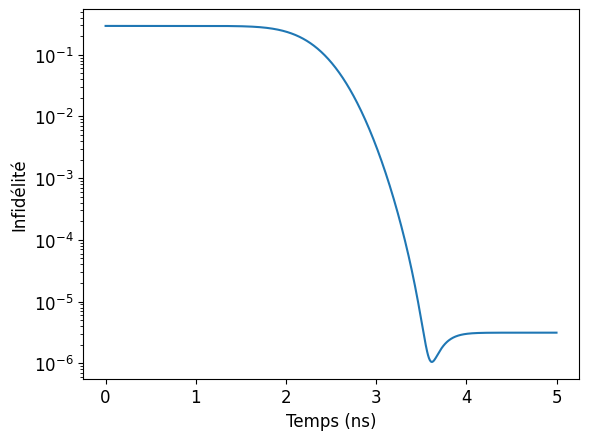

In [79]:
fidelite_gauss = [fidelity(1/np.sqrt(2)*(etat3_g-1j*etat3_e), state) for state in result_gauss.states]
plt.plot(t,fidelite_gauss)
plt.ylabel('Fidélité')
plt.xlabel('Temps (ns)')
plt.show()
plt.semilogy(t,1-np.array(fidelite_gauss))
plt.ylabel('Infidélité')
plt.xlabel('Temps (ns)')
plt.show()

### Bande passante limité

In [80]:
yf_rec = fft(rect_enveloppe(t))
T = (t[1]-t[0])
xf_rec = fftfreq(pts_time, T)

plt.plot(xf_rec, yf_rec)
plt.title("fonction porte, en fréqence")
plt.show()

plt.plot(xf_rec*1e-6, 2.0/pts_time * np.abs(yf_rec)*np.heaviside(xf_rec+250e6,1)*np.heaviside(-xf_rec+250e6,1))


# Fréquence modulé par une fonction porte
bande = 2/pts_time *yf_rec*np.heaviside(xf_rec+1,1)*np.heaviside(-xf_rec+1,1)
yinv = np.real(fft(bande))
plt.plot(t, yinv)

NameError: name 'pts_time' is not defined

def hamiltonian_t(t, args):
    """ Fonction permettant de calculer le Hamiltonien à chaque temps t. """
    H0 = args[0] #hamiltonien fixe dans le temps
    H1 = args[1]  
    time_list = args[2]
    enveloppe = args[3]
    
    idx_time = np.argmin(np.abs(time_list-t))

    return H0 + enveloppe(t)* H1